This notebook was created at 11:34 14/10/20

Binary classification of liquid crystal (LC) textures into Cholesteric phase or non-Cholesteric phase using a CNN

This notebook advances on the work done in previous notebooks (binary classification between LC phase or isotropic phase) by extending this to distinguishing between one particular LC phase (Cholesteric) and any others. 

Cholesteric was chosen as, at the current time, this is the phase for which there are the most images/videos.

The LC phases will be represented by textures obtained via Youtube videos - (Vance Williams channel).

Specifically this classification will be implemented using a simple convolutional network (CNN) - LeNet-5 inspired - as this is a CNN that is not to computationally expensive for this task.

We'll be using keras and/or tensorflow.

In [ ]:
pip install tensorflow keras numpy matplotlib

In [1]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras.backend as K

Define a function to get the image files into a usuable format (numpy.array). The images will be 368(height)x640(width) (the size of the pictures taken from Youtube videos).

In [2]:
def get_images(N_images, steps, video_filename, file_type, total_image_array, total_label_array, label):
    
    shape = (1, total_image_array.shape[1], total_image_array.shape[2],  total_image_array.shape[3])
    label_reshaped = np.array([label]).reshape(1,1)
    
    for i in range(1, N_images+1, steps):
        image = np.array(Image.open(str(video_filename) + "%05d"%(i) + str(file_type))).reshape(shape) / 255
        total_image_array = np.concatenate((total_image_array, image), axis = 0)
        total_label_array = np.concatenate((total_label_array, label_reshaped), axis = 0)
        
    print(str(video_filename) + " images loaded!")
    
    return total_image_array, total_label_array

In [3]:
def generate_data(image_shape):
    """
    Get data from images obtained from YouTube - must make sure that images from the same video are not
    spread between the training set and validation or test set - to prevent data leakage.

    Parameters
    ----------
    image_shape : tuple
        Shape of images we're dealing with
    N_isotropic : int
        Number of isotropic examples we're generating for the dataset

    Returns
    -------
    images_shuffled : np.array
        Shuffled images that were generated of size (N_examples, image height, image width, 1)
    labels_shuffled : np.array
        Labels corresponding to the shuffled images, 1 for LC and 0 for isotropic, of size (N_examples, 1)

    """
    height = image_shape[0]
    width = image_shape[1]
    
    # Get Youtube LC images and labels (1 for cholesteric, 0 else)
    vid_file_path = "C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)/Liquid_crystals-machine_learning/Images/"
    
    # training data
    images_train = np.zeros((1, height, width, 3)) # we'll need to remove this entry of zeros
    labels_train = np.zeros((1,1)) # we'll need to remove this entry of zeros
    images_train, labels_train = get_images(541, 10, vid_file_path + "Youtube_Vance_Williams-Focal_Conic_Smectic_A", ".jpeg", images_train, labels_train, label = 0)
    images_train, labels_train = get_images(541, 10, vid_file_path + "Youtube_Vance_Williams-Youtube_Vance_Williams-Smectic_F_Isotropic_flucuations", ".jpeg", images_train, labels_train, label = 0) # isotropic frames (1,11,1001,1011,1021,1901,1911,1921,1931,1941,2111,2121)
    images_train, labels_train = get_images(541, 10, vid_file_path + "Youtube_Vance_Williams-Youtube_Vance_Williams-Youtube-Vance_Williams-Cholesteric(2)", ".jpeg", images_train, labels_train, label = 1)
    images_train, labels_train = get_images(541, 10, vid_file_path + "Youtube-Vance_Williams-Cholesteric_droplets", ".jpeg", images_train, labels_train, label = 1)
    images_train, labels_train = get_images(541, 10, vid_file_path + "Youtube-Vance_Williams-Cholesteric_fluctuations", ".jpeg", images_train, labels_train, label = 1)
    images_train, labels_train = get_images(541, 10, vid_file_path + "Youtube-Vance_Williams-Cholesteric_to_Isotropic", ".jpeg", images_train, labels_train, label = 1)
    images_train, labels_train = get_images(541, 10, vid_file_path + "Youtube-Vance_Williams-Isotropic_to_Cholesteric_transition", ".jpeg", images_train, labels_train, label = 1)
    images_train, labels_train = get_images(541, 10, vid_file_path + "Youtube-Vance_Williams-Isotropic_to_Nematic", ".jpeg", images_train, labels_train, label = 0) # isotropic frames (upto and including 141)
    images_train, labels_train = get_images(541, 10, vid_file_path + "Youtube-Vance_Williams-Isotropic_to_Smectic_F(2)", ".jpeg", images_train, labels_train, label = 0) # isotropic frames (upto and including 61)    
    images_train, labels_train = get_images(541, 10, vid_file_path + "Youtube-Vance_Williams-Nematic", ".jpeg", images_train, labels_train, label = 0)
    images_train, labels_train = get_images(541, 10, vid_file_path + "Youtube-Vance_Williams-Smectic", ".jpeg", images_train, labels_train, label = 0)
    # Not included as they are complex to label
    #get_images(811, 10, vid_file_path + "Youtube-Vance_Williams-Nematic_to_Smectic_A", ".jpeg", images_LC_test)
    #get_images(631, 10, vid_file_path + "Youtube-Vance_Williams-Youtube-Vance_Williams-Smectic_C_to_Nematic_transition", ".jpeg", images_LC_test)
    
    labels_train = np.delete(labels_train, 0, axis = 0)
    images_train = np.delete(images_train, 0, axis = 0)
    
    images_train_shuffled, labels_train_shuffled = shuffle(images_train, labels_train)
    
    # holdout (val/test) data (no images that will be trained on, to avoid data leakage)
    images_holdout = np.zeros((1, height, width, 3))
    labels_holdout = np.zeros((1,1)) # we'll need to remove this entry of zeros
    images_holdout, labels_holdout = get_images(551, 10, vid_file_path + "Youtube-Vance_Williams-Cholesteric_heating", ".jpeg", images_holdout, labels_holdout, label = 1)
    images_holdout, labels_holdout = get_images(841, 10, vid_file_path + "Youtube-Vance_Williams-Cholesteric_to_Isotropic_transition", ".jpeg", images_holdout, labels_holdout, label = 1)
    images_holdout, labels_holdout = get_images(781, 10, vid_file_path + "Youtube-Vance_Williams-Cholesteric", ".jpeg", images_holdout, labels_holdout, label = 1)
    images_holdout, labels_holdout = get_images(551, 10, vid_file_path + "Youtube-Vance_Williams-Nematic_droplets_in_Isotropic", ".jpeg", images_holdout, labels_holdout, label = 0)
    images_holdout, labels_holdout = get_images(361, 10, vid_file_path + "Youtube-Vance_Williams-Isotropic_to_Smectic_F", ".jpeg", images_holdout, labels_holdout, label = 0) # isotropic frames (upto and including 61)
    
    labels_holdout = np.delete(labels_holdout, 0, axis = 0)
    images_holdout = np.delete(images_holdout, 0, axis = 0)

    # from the holdout data, genereate the validation and test datasets
    images_val, images_test, labels_val, labels_test = train_test_split(images_holdout, labels_holdout, test_size=0.5)
    
    print("All data loaded and shuffled!")
    
    return images_train_shuffled, labels_train_shuffled, images_val, labels_val, images_test, labels_test

Generate some data. (This could take a minute or so.)

In [4]:
image_shape = (368,640)
images_train, labels_train, images_val, labels_val, images_test, labels_test = generate_data(image_shape)

C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)/Liquid_crystals-machine_learning/Images/Youtube_Vance_Williams-Focal_Conic_Smectic_A images loaded!
C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)/Liquid_crystals-machine_learning/Images/Youtube_Vance_Williams-Youtube_Vance_Williams-Smectic_F_Isotropic_flucuations images loaded!
C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)/Liquid_crystals-machine_learning/Images/Youtube_Vance_Williams-Youtube_Vance_Williams-Youtube-Vance_Williams-Cholesteric(2) images loaded!
C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)/Liquid_crystals-machine_learning/Images/Youtube-Vance_Williams-Cholesteric_droplets images loaded!
C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)/Liquid_crystals-machine_learning/Images/Youtube-Vance_Williams-Cholesteric_fluctuations images loaded!
C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)/Liquid_crystals-machine_learning/Images/Youtube-Vance_Williams-Cho

Let's look at some of the images and make sure the labels are matching up.

Label: 1


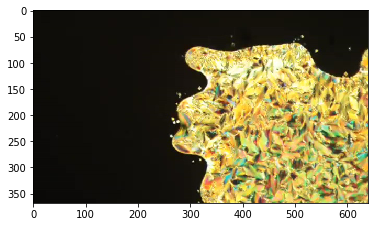

In [5]:
index = 100
plt.imshow(images_train[index,:,:,:])
print("Label: %i"%labels_train[index])

Label: 0


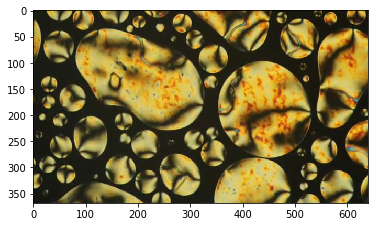

In [6]:
index = 100
plt.imshow(images_test[3,:,:,:])
print("Label: %i"%labels_test[3])

In [7]:
print ("number of training examples = " + str(images_train.shape[0]))
print ("number of validation examples = " + str(images_val.shape[0]))
print ("number of test examples = " + str(images_test.shape[0]))
print ("X_train shape: " + str(images_train.shape))
print ("Y_train shape: " + str(labels_train.shape))
print ("X_val shape: " + str(images_val.shape))
print ("Y_val shape: " + str(labels_val.shape))
print ("X_test shape: " + str(images_test.shape))
print ("Y_test shape: " + str(labels_test.shape))

number of training examples = 605
number of validation examples = 156
number of test examples = 157
X_train shape: (605, 368, 640, 3)
Y_train shape: (605, 1)
X_val shape: (156, 368, 640, 3)
Y_val shape: (156, 1)
X_test shape: (157, 368, 640, 3)
Y_test shape: (157, 1)


Define the LeNet-5 model.

In [8]:
def leNet5(input_shape):
    """
    Create an instance of model class representing LeNet-5
    inspired architecture

    Parameters
    ----------
    input_shape : tuple
        shape to be input to the CNN

    Returns
    -------
    model : instance of model class
        our LeNet-5 inspired model

    """
    # Input placeholder with shape input_shape
    X_input = Input(input_shape)
    
    # Apply 6 5x5 filter convolution with stride of 1
    X = Conv2D(6, (5,5), strides = (1,1), activation = "relu", name = "conv1")(X_input)
    # Apply maxpooling with a filter size of 2x2 and stride of 2
    X = MaxPooling2D((2,2), strides = (2,2), name = "max_pool1")(X)
    # Apply 16 5x5 filter convolution with stride of 1
    X = Conv2D(16, (5,5), strides = (1,1), activation = "relu", name = "conv2")(X)
    # Apply maxpooling with a filter size of 2x2 and stride 2
    X = MaxPooling2D((2,2), strides = (2,2), name = "max_pool2")(X)
    
    # Flatten X (convert to a vector) before going to fully
    # connected layers
    X = Flatten()(X)
    # Apply fully connected layer with 120 neurons
    X = Dense(120, activation="relu", name = "fc3")(X)
    # Apply fully connected layer with 120 neurons
    X = Dense(84, activation="relu", name = "fc5")(X)
    
    # Output a single binary classification
    X = Dense(1, activation="sigmoid", name = "fc_out")(X)
    
    # Create Keras model instance
    model = Model(inputs = X_input, outputs = X, name="LeNet-5")
    
    return model

Create the model.

In [9]:
LeNet5_model = leNet5(images_train.shape[1:])

Compile the model

In [10]:
LeNet5_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

Train the model

In [11]:
LeNet5_model.fit(x = images_train, y = labels_train, epochs = 4, batch_size = 64)

Epoch 1/4
10/10 [==============================] - 36s 4s/step - loss: 5.7846 - accuracy: 0.6512
Epoch 2/4
10/10 [==============================] - 38s 4s/step - loss: 0.1527 - accuracy: 0.9339
Epoch 3/4
10/10 [==============================] - 41s 4s/step - loss: 0.0328 - accuracy: 1.0000
Epoch 4/4
10/10 [==============================] - 45s 4s/step - loss: 0.0037 - accuracy: 1.0000


Get accuracy on the validation set.

In [12]:
test = LeNet5_model.evaluate(x = images_val, y = labels_val)
print()
print("Validation accuracy = " + str(test[1]))

5/5 [==============================] - 2s 344ms/step - loss: 3.2040 - accuracy: 0.2756

Validation accuracy = 0.2756410241127014


In [ ]:
prediction = LeNet5_model.predict(images_test)

In [ ]:
index = 149
plt.imshow(images_test[index,:,:,:])
print("Label: %i"%labels_test[index])
print("Prediction: %i"%prediction[index])

In [ ]:
print(prediction.shape)
print(labels_test.shape)

In [ ]:
for i in range(len(prediction)):
    if prediction[i] == 1:
        print("Predicted that " + str(i) + " was cholesteric.")
        
for i in range(len(labels_test)):
    if labels_test[i] == 1:
        print(str(i) + " actually was cholesteric.")

There are a few things to note from this notebook.
1. Its becomes impractically time consuming to get all the images read in from the local disk in the way done in this notebook. Possible work arounds are creating a database for the images and labels - possibly using h5py (python's HDF5 library)
2. The algorithms is currently overfitting the training data. Despite performing well in the training data (\~100%), it does not generalise well to unseen data (~60% - little better than randomly guessing). 

With the aim of increasing the accuracy on the validation set, we will now try to reduce overfitting. It can never hurt to have more data, however for now the computation time is an issue (see point 1 above). We can try adding dropout layers to the CNN and increasing the training epochs.

In [13]:
def model_with_dropout(input_shape):
    """
    Create an instance of model class representing LeNet-5
    inspired architecture

    Parameters
    ----------
    input_shape : tuple
        shape to be input to the CNN

    Returns
    -------
    model : instance of model class
        our LeNet-5 inspired model

    """
    # Input placeholder with shape input_shape
    X_input = Input(input_shape)
    
    # Apply 6 5x5 filter convolution with stride of 1
    X = Conv2D(6, (5,5), strides = (1,1), activation = "relu", name = "conv1")(X_input)
    # Dropout layer
    X = Dropout(0.2)(X)
    # Apply maxpooling with a filter size of 2x2 and stride of 2
    X = MaxPooling2D((2,2), strides = (2,2), name = "max_pool1")(X)
    # Apply 16 5x5 filter convolution with stride of 1
    X = Conv2D(16, (5,5), strides = (1,1), activation = "relu", name = "conv2")(X)
    # Dropout layer
    X = Dropout(0.2)(X)
    # Apply maxpooling with a filter size of 2x2 and stride 2
    X = MaxPooling2D((2,2), strides = (2,2), name = "max_pool2")(X)
    
    # Flatten X (convert to a vector) before going to fully
    # connected layers
    X = Flatten()(X)
    # Apply fully connected layer with 120 neurons
    X = Dense(120, activation="relu", name = "fc3")(X)
    # Dropout layer
    X = Dropout(0.5)(X)
    # Apply fully connected layer with 120 neurons
    X = Dense(84, activation="relu", name = "fc5")(X)
    # Dropout layer
    X = Dropout(0.5)(X)
    
    # Output a single binary classification
    X = Dense(1, activation="sigmoid", name = "fc_out")(X)
    
    # Create Keras model instance
    model = Model(inputs = X_input, outputs = X, name="LeNet-5")
    
    return model

Create the model

In [14]:
model_with_dropout = model_with_dropout(images_train.shape[1:])

Compile the model

In [15]:
model_with_dropout.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

Train the model

In [16]:
model_with_dropout.fit(x = images_train, y = labels_train, epochs = 8, batch_size = 64)

Epoch 1/8
10/10 [==============================] - 53s 5s/step - loss: 2.8822 - accuracy: 0.6165
Epoch 2/8
10/10 [==============================] - 52s 5s/step - loss: 0.2977 - accuracy: 0.8777
Epoch 3/8
10/10 [==============================] - 55s 5s/step - loss: 0.0942 - accuracy: 0.9769
Epoch 4/8
10/10 [==============================] - 52s 5s/step - loss: 0.0372 - accuracy: 0.9884
Epoch 5/8
10/10 [==============================] - 58s 6s/step - loss: 0.0249 - accuracy: 0.9917
Epoch 6/8
10/10 [==============================] - 55s 5s/step - loss: 0.0159 - accuracy: 0.9950
Epoch 7/8
10/10 [==============================] - 50s 5s/step - loss: 0.0049 - accuracy: 0.9983
Epoch 8/8
10/10 [==============================] - 53s 5s/step - loss: 0.0069 - accuracy: 0.9983


Get accuracy on the validation set.

In [ ]:
test_dropout = model_with_dropout.evaluate(x = images_val, y = labels_val)
print()
print("Validation accuracy = " + str(test_dropout[1]))

In [ ]:
prediction_dropout = model_with_dropout.predict(images_test)

In [ ]:
index = 149
plt.imshow(images_test[index,:,:,:])
print("Label: %i"%labels_test[index])
print("Prediction: %i"%prediction_dropout[index])

In [ ]:
for i in range(len(prediction_dropout)):
    if prediction_dropout[i] == 1:
        print("Predicted that " + str(i) + " was cholesteric.")
        
for i in range(len(labels_test)):
    if labels_test[i] == 1:
        print(str(i) + " actually was cholesteric.")

Performance has gotten worse, now we never identify anything as cholesteric...

Let's try the original model but stop training earlier to try avoid the overfitting.

In [ ]:
new_LeNet5_model = leNet5(images_train.shape[1:])

In [ ]:
new_LeNet5_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
new_LeNet5_model.fit(x = images_train, y = labels_train, epochs = 3, batch_size = 64)

In [ ]:
new_test = new_LeNet5_model.evaluate(x = images_val, y = labels_val)
print()
print("Validation accuracy = " + str(new_test[1]))

In [ ]:
new_prediction = new_LeNet5_model.predict(images_test)

In [ ]:
index = 149
plt.imshow(images_test[index,:,:,:])
print("Label: %i"%labels_test[index])
print("Prediction: %i"%new_prediction[index])

In [ ]:
for i in range(len(new_prediction)):
    if new_prediction[i] == 1:
        print("Predicted that " + str(i) + " was cholesteric.")
        
for i in range(len(labels_test)):
    if labels_test[i] == 1:
        print(str(i) + " actually was cholesteric.")